In [10]:
#download pretrained weights
!bash weights/download_weights.sh



/bin/sh: 1: sudo: not found
--2019-06-07 20:23:03--  https://pjreddie.com/media/files/yolov3.weights
Resolving web.ucsd.edu (web.ucsd.edu)... 132.239.1.231, 132.239.1.230
Connecting to web.ucsd.edu (web.ucsd.edu)|132.239.1.231|:3128... connected.
Proxy request sent, awaiting response... 206 Partial Content
Length: 248007048 (237M), 135580347 (129M) remaining [application/octet-stream]
Saving to: 'yolov3.weights'

yolov3.weights      100%[+++++++++==========>] 236.52M  77.9MB/s    in 1.7s    

2019-06-07 20:23:05 (77.9 MB/s) - 'yolov3.weights' saved [248007048/248007048]

--2019-06-07 20:23:05--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving web.ucsd.edu (web.ucsd.edu)... 132.239.1.230, 132.239.1.231
Connecting to web.ucsd.edu (web.ucsd.edu)|132.239.1.230|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: 'yolov3-tiny.weights'

yolov3-tiny.weights 100%[===================>]  33.79M  47.4MB/s  

In [11]:
import os
import sys
import tarfile
import collections
import torch
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
from torchvision import datasets
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
import argparse
from models import *
from torch.utils.data import DataLoader
from utils.logger import *
from utils.utils import *
from utils.datasets import *
from utils.parse_config import *
from terminaltables import AsciiTable
import datetime
from test import evaluate
from torch.autograd import Variable
from matplotlib.ticker import NullLocator
%matplotlib notebook


In [12]:
root = 'dataset_project'

dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = None, 
                                   target_transform = None, download = False)

dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = None, 
                                   target_transform = None, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)



In [13]:
def myimshow(image, ax=plt):
#     image = image.to('cpu').detach().numpy()
    image = np.moveaxis(image.numpy(), [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h



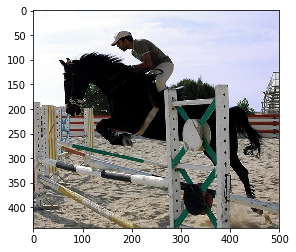

In [14]:
x, d = dataset_train[0]

plt.imshow(x)

y, f = dataset_val[1]

z, e = dataset_test[8]


In [16]:
class YOLODataset(Dataset):
    def __init__(self, dataset, img_size = (224, 224)):
        super(YOLODataset, self).__init__()
        self.img_size = img_size
#         self.augment = augment
        self.dataset = dataset
#     self.batch_count = 0
    
    def __getitem__(self, index):
        img, target = self.dataset[index]
        img = img.convert('RGB')
        transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
        img = transform(img)

        targets = None
        object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
        h = target['annotation']['size']['height']
        h = float(h)
        w = target['annotation']['size']['width']
        w = float(w)

        if isinstance(target['annotation']['object'], list):
            boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
        elif isinstance(target['annotation']['object'], dict):
            x = target['annotation']['object']['bndbox']
            boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
        else:
            print('I do not know what happened')
        boxes = np.array(boxes).astype(np.float)
        boxes = boxes.reshape(-1, 5)
        x1 = boxes[:, 1] / w
        y1 = boxes[:, 2] / h
        x2 = boxes[:, 3] / w
        y2 = boxes[:, 4] / h
        # Returns (x, y, w, h)
        box_w = (x2 - x1) 
        box_h = (y2 - y1) 
        boxes[:, 1] = ((x1 + x2) / 2)
        boxes[:, 2] = ((y1 + y2) / 2)
        boxes[:, 3] = box_w 
        boxes[:, 4] = box_h 
        
        targets = torch.zeros((len(boxes), 6))
        targets[:, 1:] = torch.Tensor(boxes)
        targets[targets != targets] = 0
    
        return img, targets
  
    def collate_fn(self, batch):
        imgs, targets = list(zip(*batch))

        targets = [boxes for boxes in targets if boxes is not None]

        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        return imgs, targets
    
    def __len__(self):
        return len(self.dataset)
    

In [19]:
trainset = YOLODataset(dataset_train)
valset = YOLODataset(dataset_val)
testset = YOLODataset(dataset_test)

print(len(trainset))
print(len(valset))
print(len(testset))


5717
11540
5823


torch.Size([3, 272, 480])
tensor([[ 0.0000, 11.0000,  0.5323,  0.3658,  0.4854,  0.7169],
        [ 0.0000, 11.0000,  0.5031,  0.5551,  0.3187,  0.6250],
        [ 0.0000, 11.0000,  0.8760,  0.2077,  0.2479,  0.4081]])


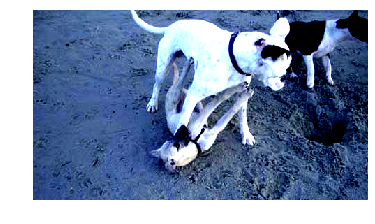

In [20]:
x, d = trainset[2]
y, f = valset[1]
z, e = testset[8]

myimshow(x)

print(x.shape)
print(d)

In [21]:
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}


class_names = list(object_to_idx.keys())
print(class_names)



['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [22]:
Argument_Dict = {}
Argument_Dict['epochs'] = 150
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'  #own model config file
Argument_Dict['pretrain_weights'] = 'For new start'
#Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_126.pth' #train start
# Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_cp_21.pth' #test
#59 mAP is 0.55
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 2
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"

print(Argument_Dict)



{'epochs': 150, 'batch_size': 8, 'model_def': 'config/yolov3-custom.cfg', 'pretrain_weights': 'For new start', 'yolov3_weights': 'weights/yolov3.weights', 'n_cpu': 2, 'gradient_accumulations': 2, 'evaluation_interval': 1, 'checkpoint_interval': 1, 'img_size': 224, 'conf_thres': 0.8, 'nms_thres': 0.4}


In [23]:
#establish checkpoints
logger = Logger("logs")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.makedirs("output", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)



cuda


In [24]:
#get pretrain weights and import darknet
model = Darknet(Argument_Dict['model_def']).to(device)
model.apply(weights_init_normal)


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [25]:
# If specified we start from checkpoint
if Argument_Dict['pretrain_weights']:
    if Argument_Dict['pretrain_weights'].endswith(".pth"):
        model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))
        print('load state dict')
    else:
        model.load_darknet_weights(Argument_Dict['yolov3_weights'])
        print('load darknet weights')
        
        

load darknet weights


In [26]:
dataloader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size= Argument_Dict['batch_size'],
    num_workers= Argument_Dict['n_cpu'],
    shuffle = True,
    pin_memory= True,
    drop_last = True,
    collate_fn= trainset.collate_fn,
)



In [29]:

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
metrics = [
    "grid_size",
    "loss",
    "x",
    "y",
    "w",
    "h",
    "conf",
    "cls",
    "cls_acc",
    "recall50",
    "recall75",
    "precision",
    "conf_obj",
    "conf_noobj",
]


In [27]:
#important !!!
#create files to save parameters only run once
save_loss_path = 'loss_list.npy'
save_map_path = 'map_list.npy'
save_precision_path = 'precision_list.npy'
if not os.path.exists(save_loss_path):
    loss_list = []
    np.save(save_loss_path, loss_list)
    print(1)
if not os.path.exists(save_map_path):
    map_list = []
    np.save(save_map_path, map_list)
    print(2)
if not os.path.exists(save_precision_path):    
    precision_list = []
    np.save(save_precision_path, precision_list)
    print(3)
    

In [31]:
for epoch in range(1,Argument_Dict['epochs']):
    model.train()
    start_time = time.time()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
#         print(imgs.cpu().numpy().shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % Argument_Dict['gradient_accumulations']:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()

        # ----------------
        #   Log progress
        # ----------------

        log_str = "\n---- [Epoch %d/%d, Batch %d/%d] ----\n" % (epoch, Argument_Dict['epochs'], batch_i, len(dataloader))

        metric_table = [["Metrics", *[f"YOLO Layer {i}" for i in range(len(model.yolo_layers))]]]

        # Log metrics at each YOLO layer
        for i, metric in enumerate(metrics):
            formats = {m: "%.6f" for m in metrics}
            formats["grid_size"] = "%2d"
            formats["cls_acc"] = "%.2f%%"
            row_metrics = [formats[metric] % yolo.metrics.get(metric, 0) for yolo in model.yolo_layers]
            metric_table += [[metric, *row_metrics]]

            # Tensorboard logging
            tensorboard_log = []
            for j, yolo in enumerate(model.yolo_layers):
                for name, metric in yolo.metrics.items():
                    if name != "grid_size":
                        tensorboard_log += [(f"{name}_{j+1}", metric)]
            tensorboard_log += [("loss", loss.item())]
            logger.list_of_scalars_summary(tensorboard_log, batches_done)

        log_str += AsciiTable(metric_table).table
        log_str += f"\nTotal loss {loss.item()}"

        print(log_str)

        model.seen += imgs.size(0)

    if epoch % Argument_Dict['evaluation_interval'] == 0:
        
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            dataset=valset, 
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=Argument_Dict['img_size'],
            batch_size=Argument_Dict['batch_size'],
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        
        logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")
        
        
        old_loss = np.load(save_loss_path)
        old_loss = old_loss.tolist()
        old_loss.append(loss.item())
#         np.save(save_loss_path)
        np.save(save_loss_path, old_loss)
        
        old_map = np.load(save_map_path)
        old_map = old_map.tolist()
        old_map.append(AP.mean())
#         np.save(save_map_path)
        np.save(save_map_path, old_map)
        
        old_precision = np.load(save_precision_path)
        old_precision = old_precision.tolist()
        old_precision.append(precision.mean())
#         np.save(save_precision_path)
        np.save(save_precision_path, old_precision)

    if epoch % Argument_Dict['checkpoint_interval'] == 0:
        torch.save(model.state_dict(), f"checkpoints/yolov3_cp_%d.pth" % epoch)
#         Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3_ckpt_%d.pth' % epoch
        
        


---- [Epoch 1/150, Batch 0/714] ----
+------------+--------------+--------------+--------------+
| Metrics    | YOLO Layer 0 | YOLO Layer 1 | YOLO Layer 2 |
+------------+--------------+--------------+--------------+
| grid_size  |  7           | 14           | 28           |
| loss       | 2.834325     | 62.757439    | 66.328842    |
| x          | 0.105405     | 0.073877     | 0.055708     |
| y          | 0.018373     | 0.039473     | 0.091718     |
| w          | 0.221629     | 0.171681     | 0.441147     |
| h          | 0.050291     | 0.181545     | 0.952493     |
| conf       | 2.274377     | 61.678356    | 64.163208    |
| cls        | 0.164250     | 0.612507     | 0.624568     |
| cls_acc    | 23.08%       | 15.38%       | 15.38%       |
| recall50   | 0.000000     | 0.000000     | 0.000000     |
| recall75   | 0.000000     | 0.000000     | 0.000000     |
| precision  | 0.000000     | 0.000000     | 0.000000     |
| conf_obj   | 0.367324     | 0.457936     | 0.473192     |
| 

KeyboardInterrupt: 